In [5]:
import pybamm
import numpy as np


no_cycles = 5
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
      "Rest for 5 hours",
      "Discharge at C/20 until 2.5 V",
      "Rest for 5 hours",
      )]* no_cycles )
#
sei_options = [ "ec reaction limited", "ec reaction limited", "ec reaction limited",  "electron-migration limited",  "interstitial-diffusion limited", "tunnelling limited" , "VonKolzenberg2020" ]
label_sei_options = ["RL", "DL", "Mixed", "EM", "ID", "ET", "VK"]  


common_params = {
    'Initial inner SEI thickness [m]': 5e-13,
    'Initial outer SEI thickness [m]': 5e-13,
    'Inner SEI electron conductivity [S.m-1]': 8.95e-15,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Inner SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
    'Lithium interstitial reference concentration [mol.m-3]': 1000,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
    'tunneling distance for electrons [m]': 0,
    'SEI reaction exchange current density [A.m-2]': 0.0003,
    "SEI open-circuit potential [V]": 0.0,
    # 'Inner SEI open-circuit potential [V]': 0.4,
    
    
}
k_sei =[ 7.0e-13, 1e-7, 1e-10,  7.0e-13,  7.0e-13,  7.0e-13,  7.0e-13]
D_sol = [1e-14,1e-22, 0.8e-22,1e-14, 1e-14, 1e-14, 1e-14 ]
inner_outer_proposionality= [0, 0, 0, 1, 0, 1, 1]
params = []
for i in range(0, len(sei_options)):
  param=pybamm.ParameterValues('Chen2020')
  param.update({**common_params, 
    'SEI kinetic rate constant [m.s-1]':k_sei[i],
    "EC diffusivity [m2.s-1]": D_sol[i],
    } ,check_already_exists=False
              )
  params.append(param)
  
  
models = [pybamm.lithium_ion.SPM({
                                  "SEI": sei_option}) for sei_option in sei_options]


solver = pybamm.CasadiSolver(mode="safe", extra_options_setup={"max_num_steps": 100000})

sims = [pybamm.Simulation(model, parameter_values=params[index],
                          experiment=exp, solver=solver) for index, model in enumerate(models)]
sols = [sim.solve(initial_soc=0) for sim in sims]


In [6]:

all_model_capacity_loss=[]
for index, model in enumerate(models):
    model_capacity_loss =[]
    for cycle_index in range(0, 5):
        time = sols[index].cycles[cycle_index]["Time [s]"].entries 
        ch_cacpacity_loss = sols[index].cycles[cycle_index]['Total capacity lost to side reactions [A.h]'](time[-1]) -\
                             sols[index].cycles[cycle_index]['Total capacity lost to side reactions [A.h]'](time[0])
        model_capacity_loss.append(ch_cacpacity_loss )
    all_model_capacity_loss.append( model_capacity_loss)

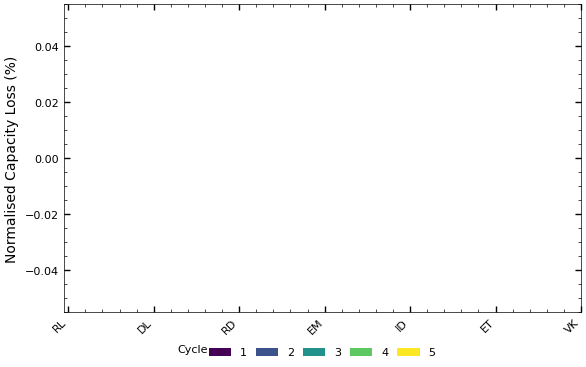

In [7]:
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.ticker as ticker
import numpy as np
from style_figs import set_plotting_format

set_plotting_format("paper")  # input should be either "presentation" or "paper"

models = ["RL", "DL", "RD", "EM", "ID", "ET", "VK"]
cycles = ['1', '2', '3', '4', '5']

fig, ax = plt.subplots(figsize=(6, 4))  # Adjust size as needed to match previous subplot size

x = np.arange(len(models))
colors = plt.cm.viridis(np.linspace(0, 1, len(cycles)))
bar_width = 0.6

bottom = np.zeros(len(models))
for i, cycle in enumerate(cycles):
    values = [model_data[i] for model_data in all_model_capacity_loss]
    
    # Normalize the data
    totals = [sum(model_data) for model_data in all_model_capacity_loss]
    normalized_values = [value / total * 100 for value, total in zip(values, totals)]
    
    ax.bar(x, normalized_values, bar_width, bottom=bottom, label=cycle, color=colors[i])
    bottom += normalized_values

ax.set_ylabel('Normalised Capacity Loss (%)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')


legend = ax.legend( bbox_to_anchor=(0.5, -0.1),
                        loc='upper center', ncol=len(cycles)+1,
                        borderaxespad=0., columnspacing=0.8)
fig.text(0.25, -.12, 'Cycle', ha='center', va='center', transform=ax.transAxes)



plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust to make room for the legend
plt.savefig("figs/capacity_fade_5cycles.png", dpi=300, bbox_inches='tight')
plt.show()